In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys
g_selfatt_source =  os.path.join(os.getcwd(), '..')
if g_selfatt_source not in sys.path:
    sys.path.append(g_selfatt_source)

In [3]:
import g_selfatt.groups as groups
import torch
import models
from g_selfatt.utils import num_params
import torch
import torchvision
from datasets import MNIST_rot
import matplotlib.pyplot as plt
import numpy as np
import models
import torch
import g_selfatt.groups as groups
import models
from torch.cuda.amp import GradScaler, autocast

/home/colin/miniconda3/envs/g_selfatt/lib/python3.7/site-packages/torch/cuda/amp/autocast_mode.py:114: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


In [4]:
model = models.GroupTransformer(
    group=groups.E2(num_elements=8),
    in_channels=1,
    num_channels=20,
    block_sizes=[2, 3],
    expansion_per_block=1,
    crop_per_layer=[2, 0, 2, 1, 1],
    image_size=28,
    num_classes=2,
    dropout_rate_after_maxpooling=0.0,
    maxpool_after_last_block=False,
    normalize_between_layers=False,
    patch_size=5,
    num_heads=9,
    norm_type="LayerNorm",
    activation_function="Swish",
    attention_dropout_rate=0.1,
    value_dropout_rate=0.1,
    whitening_scale=1.41421356,
)
model_path = "../saved/results/rotMNIST_model_p4msa_type_Local_patch_5_dpatt_0.1_dpval_0.1_activ_Swish_norm_LayerNorm_white_1.41421356_optim_Adam_lr_0.001_bs_16_ep_50_wd_0.0001_seed_0_sched_constants_schdec_1.0.pt"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torch.nn.DataParallel(model)
model.load_state_dict(torch.load(model_path, map_location=device), strict=False)

<All keys matched successfully>

In [5]:
data_mean = (0.1307,)
data_stddev = (0.3081,)
transform_test = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(data_mean, data_stddev),
    ]
)
test_set = MNIST_rot(root="../data", stage="test", download=True, transform=transform_test, data_fraction=1, only_3_and_8=True)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=1,
    shuffle=False,
    num_workers=4,
)

In [6]:
data = iter(test_loader)

In [7]:
from PIL import Image, ImageOps

/home/colin/miniconda3/envs/g_selfatt/lib/python3.7/site-packages/torchvision/transforms/functional.py:109: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629403081/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  img = torch.as_tensor(np.asarray(pic))


Target: 3


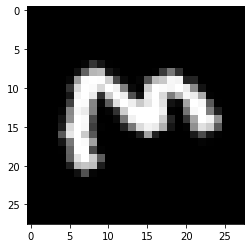

3 with probability 1.0
torch.Size([1, 20, 8, 24, 24])


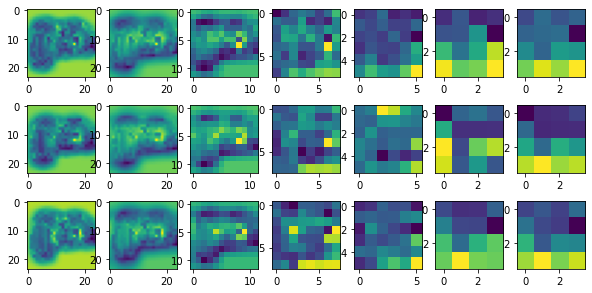

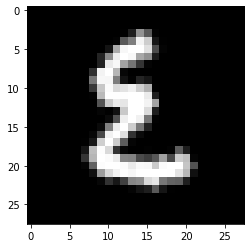

3 with probability 1.0
torch.Size([1, 20, 8, 24, 24])


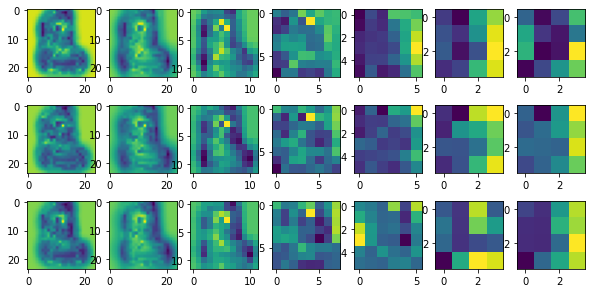

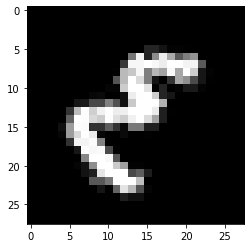

3 with probability 0.9999984502792358
torch.Size([1, 20, 8, 24, 24])


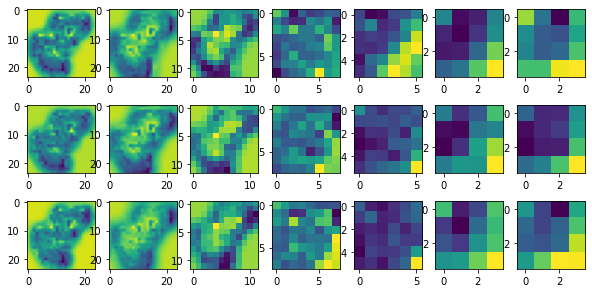

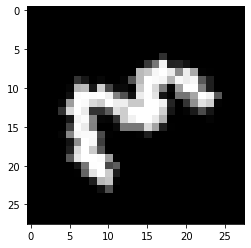

3 with probability 0.9998020529747009
torch.Size([1, 20, 8, 24, 24])


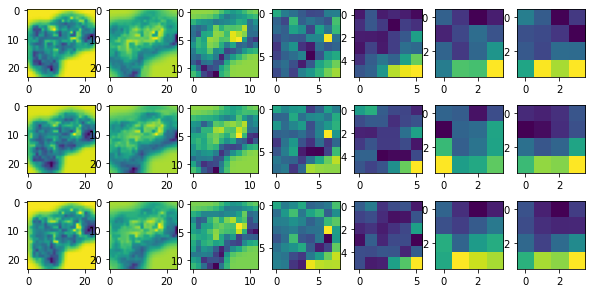

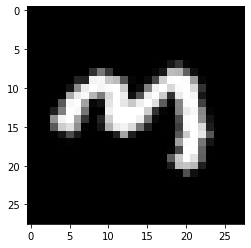

3 with probability 1.0
torch.Size([1, 20, 8, 24, 24])


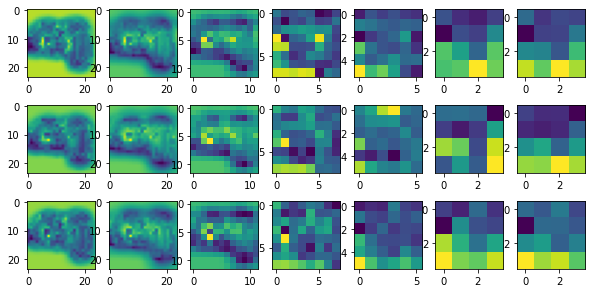

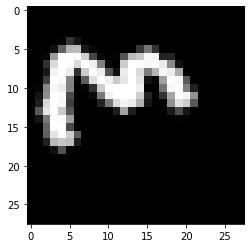

3 with probability 1.0
torch.Size([1, 20, 8, 24, 24])


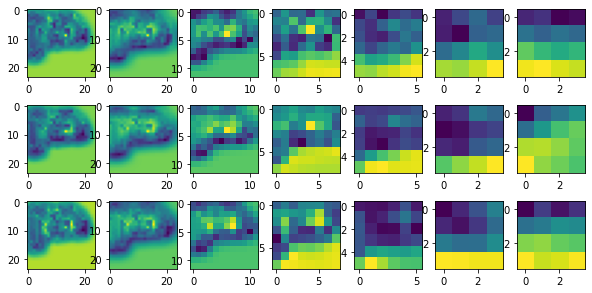

++++++++++++++++++++++++++++++
Target: 8


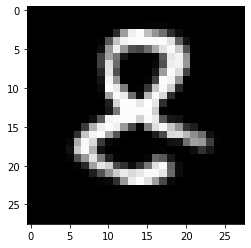

8 with probability 0.9998087286949158
torch.Size([1, 20, 8, 24, 24])


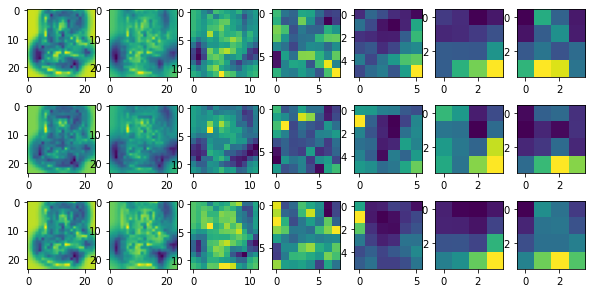

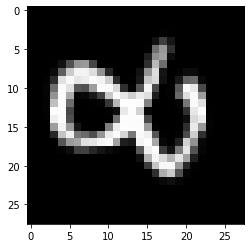

8 with probability 0.9998018145561218
torch.Size([1, 20, 8, 24, 24])


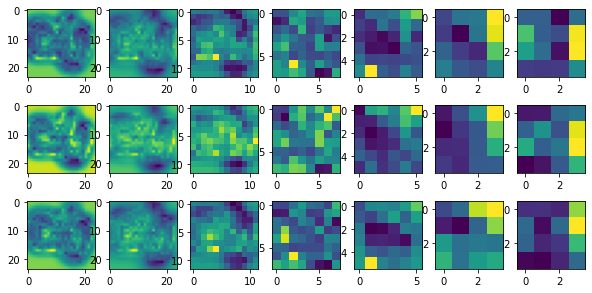

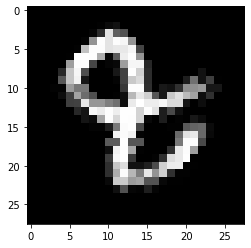

8 with probability 0.9999995231628418
torch.Size([1, 20, 8, 24, 24])


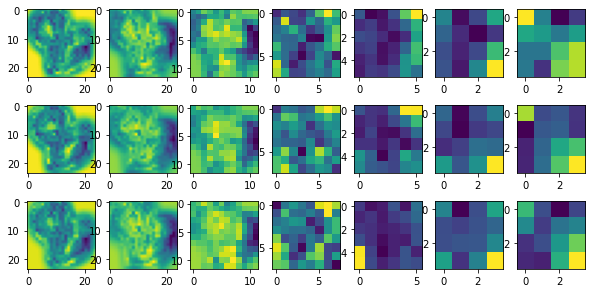

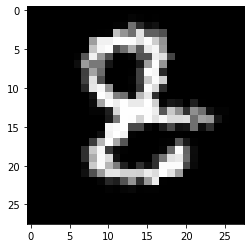

8 with probability 0.9983861446380615
torch.Size([1, 20, 8, 24, 24])


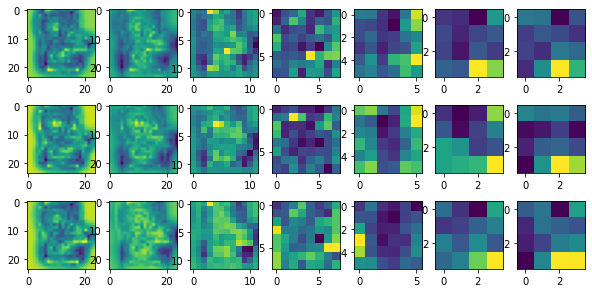

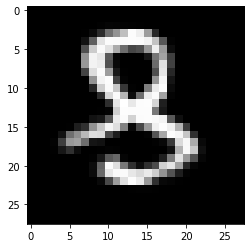

8 with probability 0.9998062252998352
torch.Size([1, 20, 8, 24, 24])


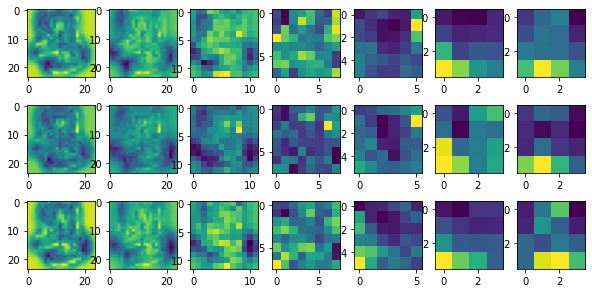

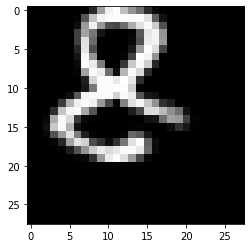

3 with probability 0.9999805688858032
torch.Size([1, 20, 8, 24, 24])


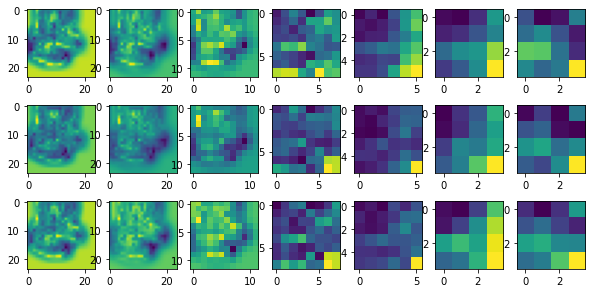

++++++++++++++++++++++++++++++


In [8]:
import torchvision.transforms.functional


idx_2_target = {
    0: 3,
    1: 8
}

model.eval()
with torch.no_grad():
    for _ in range(2):
        example_image, example_idx = next(data)
        pil_image = Image.fromarray(example_image[0,0].numpy())
        bg_color = example_image[0,0,0,0]
        rotated_image = pil_image.rotate(90, fillcolor=bg_color)
        rotated_image_tensor = torchvision.transforms.functional.pil_to_tensor(rotated_image).unsqueeze(1)
        rotated_image_2 = pil_image.rotate(45, fillcolor=bg_color)
        rotated_image_2_tensor = torchvision.transforms.functional.pil_to_tensor(rotated_image_2).unsqueeze(1)
        rotated_image_3 = pil_image.rotate(20, fillcolor=bg_color)
        rotated_image_3_tensor = torchvision.transforms.functional.pil_to_tensor(rotated_image_3).unsqueeze(1)
        flipped_image = ImageOps.mirror(pil_image)
        flipped_image_tensor = torchvision.transforms.functional.pil_to_tensor(flipped_image).unsqueeze(1)
        translated_image = pil_image.transform(pil_image.size, Image.AFFINE, (1, 0, 3, 0, 1, 3), fillcolor=bg_color) 
        # fillcolor is set assuming that top left of image is the background color 
        translated_image_tensor = torchvision.transforms.functional.pil_to_tensor(translated_image).unsqueeze(1)
        print(f"Target: {idx_2_target[example_idx.item()]}")
        for image in [example_image, rotated_image_tensor, rotated_image_2_tensor, rotated_image_3_tensor,
                      flipped_image_tensor, translated_image_tensor]:
            out = model(image)
            features = model(image, show_features=True)
            image = image.squeeze()  # Batch dimension
            plt.imshow(image.cpu().numpy(), cmap="gray")
            plt.show()
            _, preds = torch.max(out, 1)
            print(f"{idx_2_target[preds.item()]} with probability {torch.softmax(out, dim=1)[0][preds].item()}")
            print(features[0].shape) # [batch size, channels, group elements, x ,y]
            plt.figure(figsize=(10, 5))
            for i in range(len(features)):
                for j in range(3):
                    plt.subplot(3, len(features), j*len(features) + i+1)
                    plt.imshow(features[i][0,0,j])
            plt.show()
        print("++++++++++++++++++++++++++++++")

In [9]:
model2 = models.GroupTransformer(
    group=groups.E2(num_elements=8),
    in_channels=1,
    num_channels=20,
    block_sizes=[2, 3],
    expansion_per_block=1,
    crop_per_layer=[2, 0, 2, 1, 1],
    image_size=28,
    num_classes=2,
    dropout_rate_after_maxpooling=0.0,
    maxpool_after_last_block=False,
    normalize_between_layers=False,
    patch_size=5,
    num_heads=9,
    norm_type="LayerNorm",
    activation_function="Swish",
    attention_dropout_rate=0.1,
    value_dropout_rate=0.1,
    whitening_scale=1.41421356,
    return_attn_probs=True,
)
model_path = "../saved/results/rotMNIST_model_p4msa_type_Local_patch_5_dpatt_0.1_dpval_0.1_activ_Swish_norm_LayerNorm_white_1.41421356_optim_Adam_lr_0.001_bs_16_ep_50_wd_0.0001_seed_0_sched_constants_schdec_1.0.pt"
device2 = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model2 = torch.nn.DataParallel(model2)
model2.load_state_dict(torch.load(model_path, map_location=device2), strict=False)

<All keys matched successfully>

torch.Size([1, 20, 8, 28, 28]) torch.Size([1, 9, 8, 28, 28, 5, 5])
Target: 8


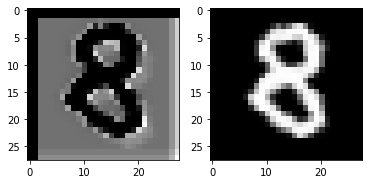

torch.Size([1, 20, 8, 28, 28]) torch.Size([1, 9, 8, 28, 28, 5, 5])
Target: 8


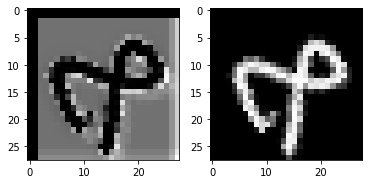

torch.Size([1, 20, 8, 28, 28]) torch.Size([1, 9, 8, 28, 28, 5, 5])
Target: 8


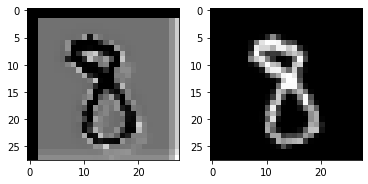

torch.Size([1, 20, 8, 28, 28]) torch.Size([1, 9, 8, 28, 28, 5, 5])
Target: 8


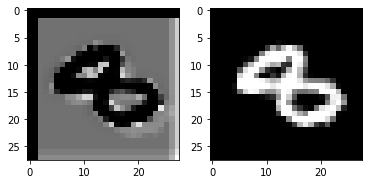

torch.Size([1, 20, 8, 28, 28]) torch.Size([1, 9, 8, 28, 28, 5, 5])
Target: 3


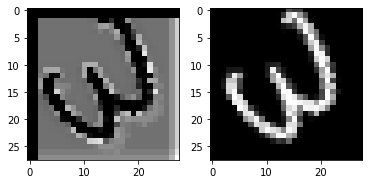

torch.Size([1, 20, 8, 28, 28]) torch.Size([1, 9, 8, 28, 28, 5, 5])
Target: 3


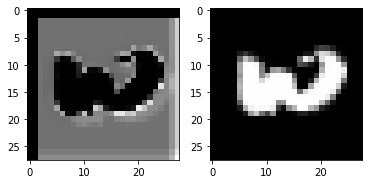

torch.Size([1, 20, 8, 28, 28]) torch.Size([1, 9, 8, 28, 28, 5, 5])
Target: 8


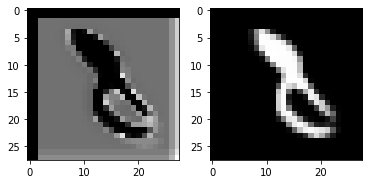

torch.Size([1, 20, 8, 28, 28]) torch.Size([1, 9, 8, 28, 28, 5, 5])
Target: 3


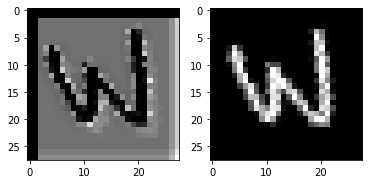

torch.Size([1, 20, 8, 28, 28]) torch.Size([1, 9, 8, 28, 28, 5, 5])
Target: 8


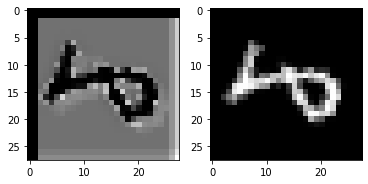

torch.Size([1, 20, 8, 28, 28]) torch.Size([1, 9, 8, 28, 28, 5, 5])
Target: 3


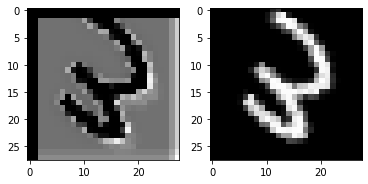

In [10]:
idx_2_target = {
    0: 3,
    1: 8
}

model2.eval()
with torch.no_grad():
    for _ in range(10):
        example_image, example_idx = next(data)
        out, attn = model2(example_image)
        attn_image = attn[0,0,0,:,:,0,0]
        plt.subplot(1,2,1)
        plt.imshow(attn_image.cpu().numpy(), cmap='gray')
        print(out.shape, attn.shape)
        example_image = example_image.squeeze()  # Batch dimension
        print(f"Target: {idx_2_target[example_idx.item()]}")
        plt.subplot(1,2,2)
        plt.imshow(example_image.cpu().numpy(), cmap="gray")
        plt.show()
        # _, preds = torch.max(out, 1)
        # print(f"{idx_2_target[preds.item()]} with probability {torch.softmax(out, dim=1)[0][preds].item()}")

In [11]:
# for name, param in model.named_parameters():
#     print(name)

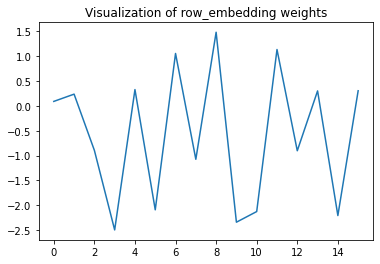

In [12]:
module = model.module
weights = module.lifting_self_attention.row_embedding[0].weight.detach().cpu().numpy()

plt.plot(weights.squeeze())
plt.title('Visualization of row_embedding weights')
plt.show()

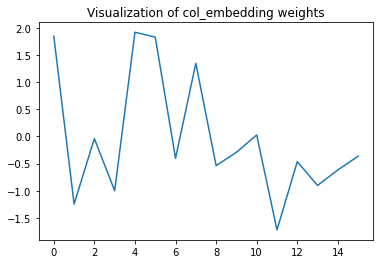

In [13]:
weights = module.lifting_self_attention.col_embedding[0].weight.detach().cpu().numpy()
plt.plot(weights.squeeze())
plt.title('Visualization of col_embedding weights')
plt.show()

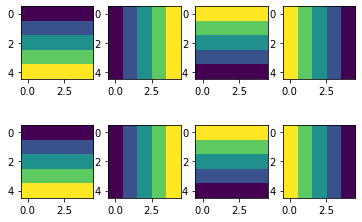

In [14]:
row_indices = module.lifting_self_attention.col_indices

for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(row_indices[i])




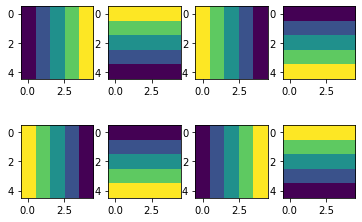

In [15]:
col_indices = module.lifting_self_attention.col_indices

for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(col_indices[i])


# transformer block 0 embedding indices visualisation

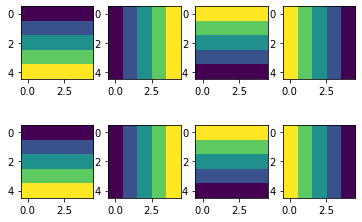

In [16]:
row_indices = module.transformer[0].attention[2].row_indices

for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(row_indices[i])


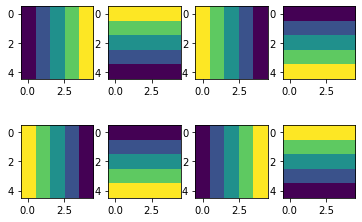

In [17]:
col_indices = module.transformer[0].attention[2].col_indices

for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(col_indices[i])


# transformer block 0 embedding visualisation

torch.Size([8, 5, 5])
(8, 5, 5, 3)


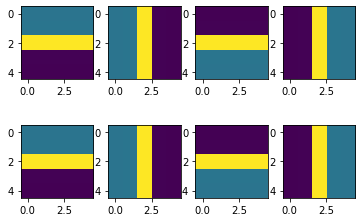

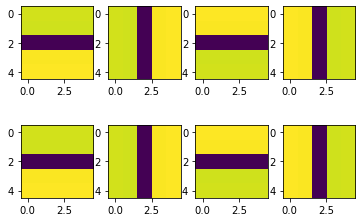

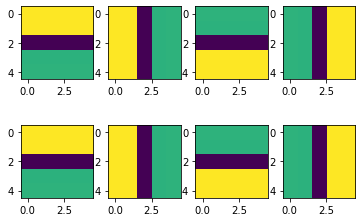

[[0.80237114 0.80237114 0.80237114 0.80237114 0.80237114]
 [0.8070122  0.8070122  0.8070122  0.8070122  0.8070122 ]
 [1.5158756  1.5158756  1.5158756  1.5158756  1.5158756 ]
 [0.36383972 0.36383972 0.36383972 0.36383972 0.36383972]
 [0.358932   0.358932   0.358932   0.358932   0.358932  ]]


In [50]:
row_indices = module.transformer[0].attention[2].row_indices

print(row_indices.shape)

final_row_embedding = module.transformer[0].attention[2].row_embedding(row_indices.view(-1, 1, 1, 1)).view(row_indices.shape + (-1,)).detach().numpy()
final_row_embedding = module.transformer[0].attention[2].row_embedding(row_indices.view(-1, 1, 1, 1)).view(row_indices.shape + (-1,)).detach().numpy()

print(final_row_embedding.shape)

for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(final_row_embedding[i,:,:,0])

plt.show()

for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(final_row_embedding[i,:,:,1])

plt.show()

for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(final_row_embedding[i,:,:,2])

plt.show()


torch.Size([8, 5, 5])
(8, 5, 5, 3)


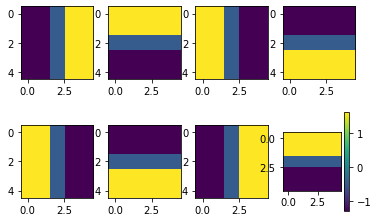

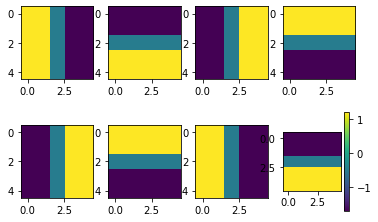

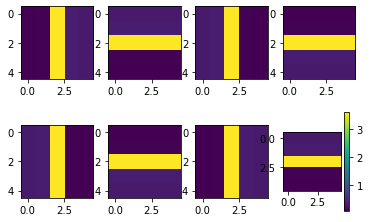

In [64]:
col_indices = module.transformer[0].attention[2].col_indices

print(col_indices.shape)

final_col_embedding = module.transformer[0].attention[2].col_embedding(col_indices.view(-1, 1, 1, 1)).view(col_indices.shape + (-1,)).detach().numpy()
final_col_embedding = module.transformer[0].attention[2].col_embedding(col_indices.view(-1, 1, 1, 1)).view(col_indices.shape + (-1,)).detach().numpy()

print(final_col_embedding.shape)

for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(final_col_embedding[i,:,:,0])

plt.colorbar()

plt.show()

for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(final_col_embedding[i,:,:,1])

plt.colorbar()

plt.show()

for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(final_col_embedding[i,:,:,2])

plt.colorbar()

plt.show()


## transformer block 2 embedding kernel weight visualisation

torch.Size([8, 5, 5])
(8, 5, 5, 3)


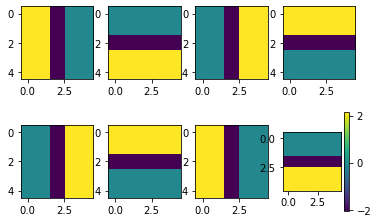

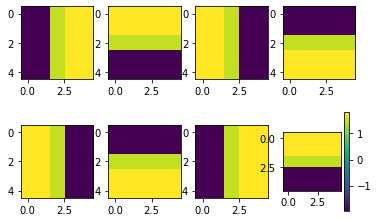

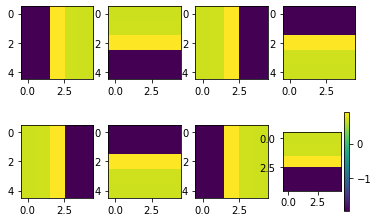

In [63]:
col_indices = module.transformer[3].attention[2].col_indices

print(col_indices.shape)

final_col_embedding = module.transformer[3].attention[2].col_embedding(col_indices.view(-1, 1, 1, 1)).view(col_indices.shape + (-1,)).detach().numpy()
final_col_embedding = module.transformer[3].attention[2].col_embedding(col_indices.view(-1, 1, 1, 1)).view(col_indices.shape + (-1,)).detach().numpy()

print(final_col_embedding.shape)

for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(final_col_embedding[i,:,:,0])

plt.colorbar()

plt.show()

for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(final_col_embedding[i,:,:,1])

plt.colorbar()

plt.show()

for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(final_col_embedding[i,:,:,2])

plt.colorbar()

plt.show()


## transformer block 0 embedding kernel weight visualisation

(16, 1, 1, 1)


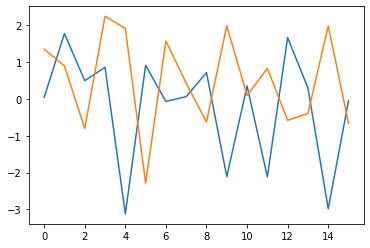

In [79]:
weights_row = module.transformer[0].attention[2].row_embedding[0].weight.detach().cpu().numpy()
weights_col = module.transformer[0].attention[2].col_embedding[0].weight.detach().cpu().numpy()

plt.plot(weights_row.squeeze())
plt.plot(weights_col.squeeze())

print(weights_col.shape)

plt.show()

(3, 16, 1, 1)


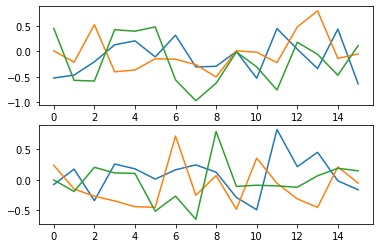

In [80]:
weights_row = module.transformer[0].attention[2].row_embedding[3].weight.detach().cpu().numpy()
weights_col = module.transformer[0].attention[2].col_embedding[3].weight.detach().cpu().numpy()

print(weights_row.shape)
plt.subplot(211)
plt.plot(weights_col.squeeze().T)
plt.subplot(212)
plt.plot(weights_row.squeeze().T)
plt.show()

[ 1.355378    0.8991513  -0.800233    2.2508502   1.9188323  -2.28629
  1.578074    0.42812335 -0.6247775   1.9950341   0.09863157  0.83197385
 -0.581095   -0.39266762  1.9909202  -0.6613471 ]


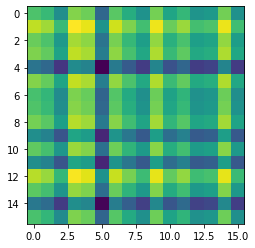

In [74]:
weights_row = module.transformer[0].attention[2].row_embedding[0].weight.detach().cpu().numpy()
weights_col = module.transformer[0].attention[2].col_embedding[0].weight.detach().cpu().numpy()

print(weights_col.squeeze())

combo = np.zeros((16, 16))

for i in range(16):
    for j in range(16):
        combo[i][j] = weights_row.squeeze()[i] + weights_col.squeeze()[j]

plt.imshow(combo)

plt.show()

(16,)


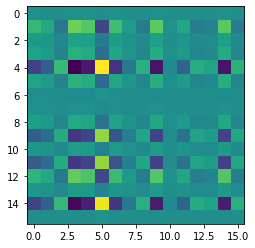

In [73]:
weights_row = module.transformer[0].attention[2].row_embedding[0].weight.detach().cpu().numpy()
weights_col = module.transformer[0].attention[2].col_embedding[0].weight.detach().cpu().numpy()

print(weights_row.squeeze().shape)


combo = np.zeros((16, 16))

for i in range(16):
    for j in range(16):
        combo[i][j] = weights_row.squeeze()[i] * weights_col.squeeze()[j]

plt.imshow(combo)
plt.show()

In [76]:
# Iterate over named modules
# for name, module in model.named_modules():
    # print(name)

In [ ]:
# todo visualize attention and all the different layers
# just a bunch of explainability